In [124]:
from aicsimageio import AICSImage
import numpy as np
import ast
import seaborn as sns
import napari
from skimage import measure as meas
from scipy.signal import savgol_filter
from scipy import ndimage as ndi
from scipy import stats
from skimage import morphology as morph
from skimage.measure import regionprops
from skimage.morphology import medial_axis
import tidynamics as td
import sys,os
import skimage as skimage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable 
from tqdm import tqdm
import matplotlib as mpl
from matplotlib import rc
import pandas as pd
from openpiv import tools, pyprocess, validation, filters, scaling 
from skimage.filters import threshold_otsu

plt.style.use('default')
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':20})
rc('text', usetex=False)
rc('axes', titlesize=18, labelsize=20)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16



In [211]:
path = '/Users/localadmin/Desktop/Fluidlab/Projects/Sonnen_lab/Data for Mazi/Maximum intensity projections/'
prefix = 't'
suffix = '_iRFP.tif'

i = 86
j = i+1



frame_a  = tools.imread(path+prefix+str(i).zfill(4)+suffix)
frame_b  = tools.imread(path+prefix+str(j).zfill(4)+suffix)
frame_a = ndi.gaussian_filter(frame_a,sigma=3)
frame_b = ndi.gaussian_filter(frame_b,sigma=3)

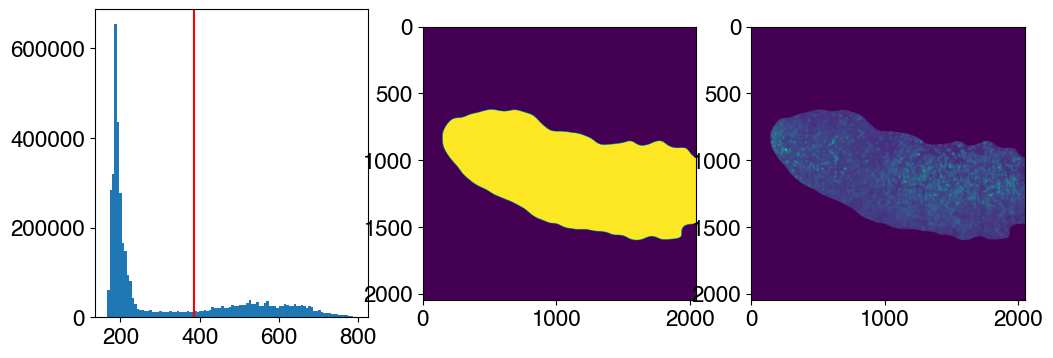

In [212]:
frame_a_gau = ndi.gaussian_filter(frame_a,sigma=35)
thresh = threshold_otsu(frame_a_gau)
mask = frame_a_gau>thresh
mask = morph.erosion(mask,morph.disk(21))

# frame_a = ndi.white_tophat(frame_a,structure=morph.disk(7))
# frame_b = ndi.white_tophat(frame_b,structure=morph.disk(7))
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(12,4))
ax1.hist(frame_a_gau.flatten(),bins=100)
ax1.axvline(thresh,c='r')
ax2.imshow(mask)
ax3.imshow(frame_a*mask)
plt.show()

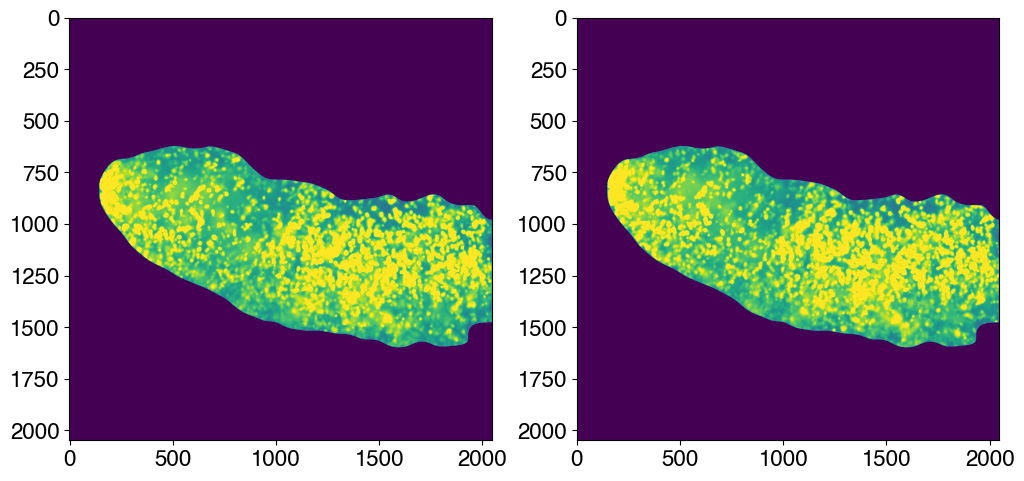

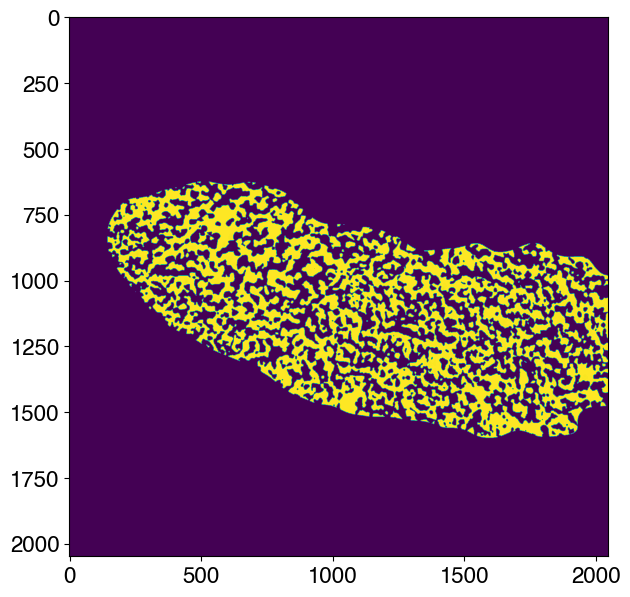

In [213]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a*mask,vmin=50,vmax=700)
ax[1].imshow(frame_b*mask,vmin=50,vmax=700)
plt.show()
fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow((frame_a-frame_b)*mask)
plt.show()

In [218]:
winsize = 54 # pixels, interrogation window size in frame A
searchsize = 94  # pixels, search in image B
overlap = 0 # pixels, 50% overlap
dt = 0.02 # sec, time interval between pulses


u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32)*mask, 
                                                       frame_b.astype(np.int32)*mask, 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=1, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

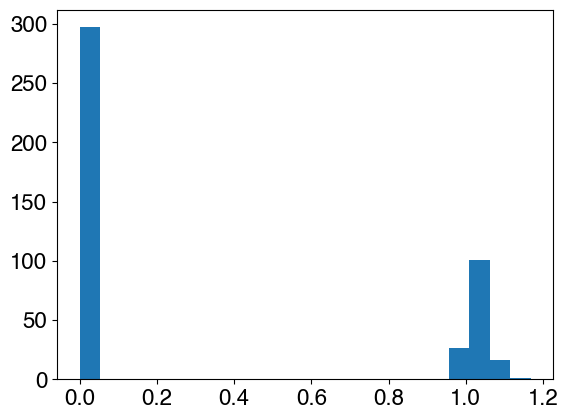

In [219]:
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )
plt.figure()
plt.hist(sig2noise.flatten(),bins=int(np.sqrt(len(sig2noise))*5))
plt.show()

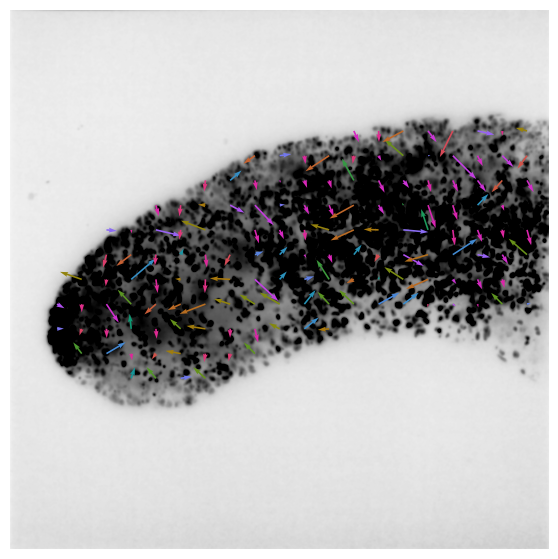

In [220]:
import cmocean

cmap = cmocean.cm.phase
norm = plt.Normalize(vmin=0,vmax=2*np.pi)

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(frame_a,origin='lower',cmap='Greys',vmin=100,vmax=600)
ax.quiver(x,y,u0,v0,np.arctan2(v0,u0),cmap=cmocean.cm.phase,width=0.003)
ax.set_axis_off()
plt.show()

In [139]:
flags = validation.sig2noise_val(u0,v0, sig2noise, threshold = 1.02 )
# filter out outliers that are very different from the
# neighbours

u2, v2 = filters.replace_outliers( u0, v0, 
                                   flags,
                                   method='localmean', 
                                   max_iter=3, 
                                   kernel_size=3)

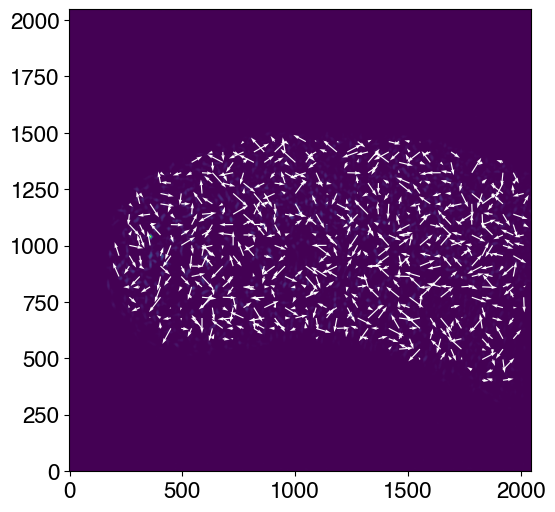

In [121]:
fig, ax = plt.subplots(figsize=(6,6))


invalid = flags[2] # mask.astype("bool") 
valid = ~invalid 
ax.imshow(frame_a,origin='lower')
ax.quiver(x[valid],y[valid],u0[valid],v0[valid],color="w",width=0.0025)

# TBD:
* multistep-refining of flow field (windowsize, but also $\tau$ of frame($t$), frame($t+\tau$))
* Safe flow fields for all time steps.
* make interactive plot for t



In [199]:
def run_piv(frame_a,frame_b,sig,winsize,searchsize,overlap,snr_thresh):
    '''
    This function makes a complete run of the above defined PIV algo
    frame_a (2d array):         first frame
    frame_b (2d array):         second frame
    sig (float):                sigma for gaussian filtering for threshold creation
    winsize (int, odd):         window size
    searchsize (int, >winsize): size of search window
    overlap (int):              overlap of windows
    snr_thresh (float):         threshold for signal to noise ratio
    '''

    frame_a = ndi.gaussian_filter(frame_a,sigma=3)
    frame_b = ndi.gaussian_filter(frame_b,sigma=3)
    # frame_a = ndi.white_tophat(frame_a,structure=morph.disk(7))
    # frame_b = ndi.white_tophat(frame_b,structure=morph.disk(7))
    
    frame_a_gau = ndi.gaussian_filter(frame_a,sigma=sig)
    thresh = threshold_otsu(frame_a_gau)
    mask = frame_a_gau>thresh
    mask = morph.erosion(mask,morph.disk(21))

    u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32)*mask, 
                                                        frame_b.astype(np.int32)*mask, 
                                                        window_size=winsize, 
                                                        overlap=overlap, 
                                                        dt=1, 
                                                        search_area_size=searchsize, 
                                                        sig2noise_method='peak2peak')
    x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )
    
    flags = validation.sig2noise_val(u0,v0, sig2noise, threshold = snr_thresh )
    # filter out outliers that are very different from the
    # neighbours

    u2, v2 = filters.replace_outliers( u0, v0, 
                                    flags,
                                    method='localmean', 
                                    max_iter=3, 
                                    kernel_size=3)
    return x,y,u0,v0,u2,v2,flags

def plot_piv_rslt(frame_a,x,y,u0,v0,u2,v2,flags,path):
    fig, ax = plt.subplots(figsize=(6,6))
    invalid = flags[2] # mask.astype("bool") 
    valid = ~invalid 
    ax.imshow(frame_a,origin='lower',cmap='Greys_r',vmin=50,vmax=500)
    ax.quiver(x[valid],y[valid],u0[valid],v0[valid],np.arctan2(v0[valid],u0[valid]),cmap=cmocean.cm.phase,width=0.0025)
    plt.savefig(path)
    plt.close()

In [200]:
path = '/Users/localadmin/Desktop/Fluidlab/Projects/Sonnen_lab/Data for Mazi/Maximum intensity projections/'
prefix = 't'
suffix = '_iRFP.tif'
save_path = '/Users/localadmin/Desktop/Fluidlab/Projects/Sonnen_lab/Data for Mazi/PIV_output/'
image_path = '/Users/localadmin/Desktop/Fluidlab/Projects/Sonnen_lab/Data for Mazi/PIV_imgs/'
dt = 5

for i in tqdm(np.arange(dt+1,100)-dt):
    j = i+dt

    frame_a  = tools.imread(path+prefix+str(i).zfill(4)+suffix)
    frame_b  = tools.imread(path+prefix+str(j).zfill(4)+suffix)
    # piv_rslt = x,y,u0,v0,u2,v2,flags
    piv_rslt = run_piv(frame_a,frame_b,sig=39,winsize=48,searchsize=64,overlap=16,snr_thresh=1.02) 
    plot_piv_rslt(frame_a,*piv_rslt,image_path+'PIV_'+prefix+str(i).zfill(4)+suffix[:-4]+'.png')
    np.save(save_path+'PIV_'+prefix+str(i).zfill(4)+suffix[:-4]+'.npy', np.array(piv_rslt, dtype=object), allow_pickle=True)

100%|██████████| 94/94 [12:07<00:00,  7.74s/it]


# Optical flow

In [261]:
import opyf
save_image_path = '/Users/localadmin/Desktop/Fluidlab/Projects/Sonnen_lab/Data for Mazi/opticalFlow_imgs/'

Dimensions :
 	 Width : 2048 Height : 2048
Regio Of Interest :
 	 [0, 0, 2048, 2048]

Good Features To Track Parameters:
	-  maxCorners : 40000
	-  qualityLevel : 0.005
	-  minDistance : 5
	-  blockSize : 16

Optical Flow Parameters:
	-  winSize : (16, 16)
	-  maxLevel : 3
	-  criteria : (3, 50, 0.03)

Filters Params:
	-  RadiusF : 30
	-  minNperRadius : 0
	-  maxDevInRadius : inf
	-  wayBackGoodFlag : inf
	-  CLAHE : False
	-  range_Vx : [-inf, inf]
	-  range_Vy : [-inf, inf]
	-  clplim : 3
	-  gridSize : (20, 20)

Interpolation Parameters:
	-  Radius : 30
	-  Sharpness : 8
	-  kernel : Gaussian

[The following image processing plan has been set]
--> detect Good Features to Track on image [t0001_iRFP.tif]
--> diplacements measurement between images [t0001_iRFP.tif] and [t0002_iRFP.tif]
number of frames : 100
Velocity limits:  2
	 minimum norm velocity:  2
	 maximum norm velocity:  90

Filters Params:
	-  RadiusF : 30
	-  minNperRadius : 0
	-  maxDevInRadius : inf
	-  wayBackGoodFlag :

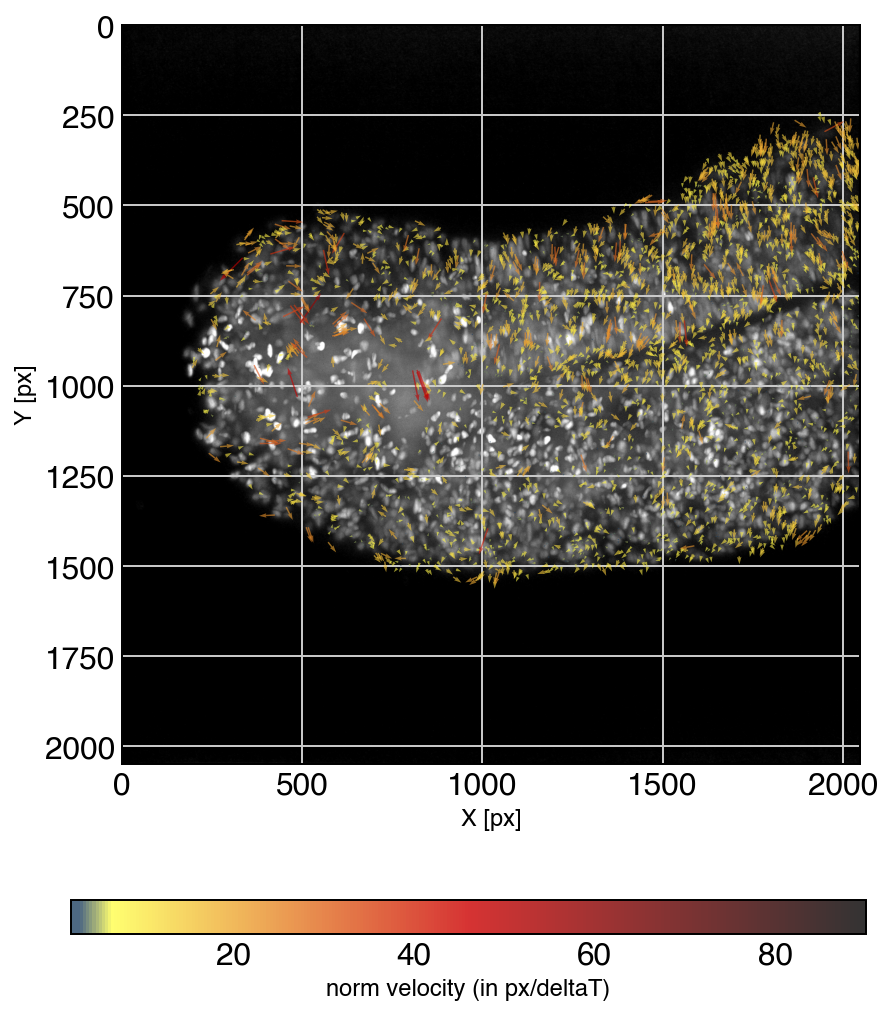

In [268]:
frames = opyf.frameSequenceAnalyzer(path,imreadOption=2,
                                    rangeOfPixels=[200, 900],)
frames.set_vlim([2,90])
frames.set_filtersParams(wayBackGoodFlag=4)
frames.extractGoodFeaturesAndDisplacements();

In [ ]:
frames.set_vecTime(Ntot=99,shift=1,step=1)
frames.extractGoodFeaturesAndDisplacements(saveImgPath=save_image_path, numberingOutput=True, nvec=1000, width=0.005);

In [272]:

frames.set_trackingFeatures(Ntot=99, step=1, starting_frame=1, track_length=5, detection_interval=1)
frames.extractTracks(display='tracks', displayColor=True, saveImgPath=save_image_path+'tracks_', numberingOutput=True)


Tracking processing 
Tracking operates only in succesives images sperated with [step] frames
Starting frame : [1]
--> Tracking operate from frame [2] to [99]
On the first frame, only Good Features to Track are detected
Maximum tracking length are [5]
Good features detection are reloaded every [1] frames
After[extractTracks] method, tracks are stored in [tracks], 
For saving them run [writeTracks]

Filters Params:
	-  RadiusF : 30
	-  minNperRadius : 0
	-  maxDevInRadius : inf
	-  wayBackGoodFlag : 1
	-  CLAHE : False
	-  range_Vx : [-inf, inf]
	-  range_Vy : [-inf, inf]
	-  clplim : 3
	-  gridSize : (20, 20)
Tracking processing...
Good feature detection processing...
----- Number of new features detected :24154

-------------- [Tracking - Step 1 / 99] --------------
------- From frame [t0001_iRFP.tif] to frame [t0002_iRFP.tif] -------
Number of Good Feature To Track = 0
No displacements measured (consider changing parameters set if displacements expected between these two frames)
Trac

FileNotFoundError: [Errno 2] No such file or directory: '/Users/localadmin/Desktop/Fluidlab/Projects/Sonnen_lab/Data for Mazi/opticalFlow_imgs/tracks_/tracks_0000.png'

Error in callback <function flush_figures at 0x15aaa5c10> (for post_execute):


KeyboardInterrupt: 

In [251]:
frames.writeGoodFeaturesPositionsAndDisplacements(fileFormat='csv', outFolder=save_path)


/usr/local/lib/python3.9/site-packages/opyf/Analyzer.py:971: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  XpROI = np.array(XpROI)


[log] parameters of the image processing saved in /Users/localadmin/Desktop/Fluidlab/Projects/Sonnen_lab/Data for Mazi/PIV_output//params_image_processing.json


In [ ]:
frames.set_trackingFeatures(Ntot=48, step=1, starting_frame=1, track_length=5, detection_interval=10)
frames.extractTracks(display='quiver', displayColor=True,
                    saveImgPath=image_path, numberingOutput=True)